In [57]:
# omitir warning
import warnings

warnings.filterwarnings("ignore")

In [58]:
import pandas as pd
import numpy as np

# Definir las capitales de los estados de México con coordenadas aproximadas (latitud, longitud)
capitales_mexico = [
    ("Aguascalientes", 21.8833, -102.2833),
    ("Baja California", 32.6519, -115.4683),
    ("Baja California Sur", 24.1426, -110.3128),
    ("Campeche", 19.8458, -90.5238),
    ("Chiapas", 16.75, -93.1167),
    ("Chihuahua", 28.6353, -106.0889),
    ("Ciudad de México", 19.4326, -99.1332),
    ("Coahuila", 25.438, -100.9786),
    ("Colima", 19.2433, -103.725),
    ("Durango", 24.0277, -104.6532),
    ("Guanajuato", 21.019, -101.2574),
    ("Guerrero", 17.5669, -99.5148),
    ("Hidalgo", 20.125, -98.7333),
    ("Jalisco", 20.6597, -103.3496),
    ("Estado de México", 19.3574, -99.6307),
    ("Michoacán", 19.7036, -101.19),
    ("Morelos", 18.9186, -99.234),
    ("Nayarit", 21.508, -104.895),
    ("Nuevo León", 25.6667, -100.3167),
    ("Oaxaca", 17.0833, -96.75),
    ("Puebla", 19.0413, -98.2062),
    ("Querétaro", 20.5931, -100.3928),
    ("Quintana Roo", 18.5, -88.3),
    ("San Luis Potosí", 22.1565, -100.9855),
    ("Sinaloa", 24.8069, -107.3932),
    ("Sonora", 29.0729, -110.9559),
    ("Tabasco", 17.9896, -92.9289),
    ("Tamaulipas", 24.2669, -98.8363),
    ("Tlaxcala", 19.3139, -98.2416),
    ("Veracruz", 19.1738, -96.1342),
    ("Yucatán", 20.9674, -89.5926),
    ("Zacatecas", 22.7709, -102.5833),
]

# Crear un DataFrame con la información de las capitales de los estados de México
capitales_df = pd.DataFrame(capitales_mexico, columns=["Capital", "Latitud", "Longitud"])

# definicion de funcion a la que se le pasa un estado y devuelve su latitud y longitud
def get_lat_lon(estado):
    return capitales_df.query(f"Capital == '{estado}'")[["Latitud", "Longitud"]].values[0]



In [59]:
# calculo de salario promedio para el trabajador
fuente_salario_1_mensual = 15000
horas_salario_1 = 10

fuente_salario_2_mensual = 14000
horas_salario_2 = 8

dias_trabajados = 27

# salario global por horas promedio
salario_hora_1 = fuente_salario_1_mensual / (horas_salario_1 * dias_trabajados)
salario_hora_2 = fuente_salario_2_mensual / (horas_salario_2 * dias_trabajados)

salario_final = (salario_hora_1 + salario_hora_2) / 2

round(salario_final, 2)

60.19

In [60]:
## definicion de la funcion de costo
def trip_cost(distanceMeters, duration, tollInfo, salaryPerHour, verbose = False):
    # Distancia y duración
    distance_km = distanceMeters / 1000
    duration_hours = int(duration[:-1]) / 3600  # Convertir duración a horas

    # Calcular costos de peaje
    toll_info = tollInfo
    toll_cost = 0
    if toll_info:
        for toll in toll_info:
            units = float(toll.get("units", 0))
            nanos = float(toll.get("nanos", 0))
            toll_cost += units + nanos / 1e9
    
    # Costos del viaje
    consumptionPerKM = 23.8  # Consumo de combustible por kilómetro
    fuelPricePerLiter = 20.5  # Precio de la gasolina por litro

    seller_cost = duration_hours * salaryPerHour # Salario por hora
    fuel_cost = (distance_km / consumptionPerKM) * fuelPricePerLiter  # Gasto en combustible
    total_cost = seller_cost + fuel_cost + toll_cost

    if verbose:
        # Imprimir resultados
        print("Costo del viaje:")
        print(f"    Distancia: {distance_km:.2f} km")
        print(f"    Duración estimada: {duration_hours:.2f} horas")
        print(f"    Costo de peajes: ${toll_cost:.2f} MXN")
        print(f"    Costo de salario: ${seller_cost:.2f} MXN")
        print(f"    Costo de combustible: ${fuel_cost:.2f} MXN")
        print(f"    Costo total del viaje: ${total_cost:.2f} MXN")

    return total_cost

In [61]:
# calculo de las distancias entre las capitales de los estados de México
# usando la api de google maps

import requests
import os
import requests

def calculate_trip_cost(api_key, origin_coords, destination_coords, salaryPerHour, verbose = False):
    # Endpoint de la API de Routes
    url = "https://routes.googleapis.com/directions/v2:computeRoutes"
    
    # Estructura de la solicitud
    payload = {
        "origin": {
            "location": {
                "latLng": {
                    "latitude": origin_coords[0],
                    "longitude": origin_coords[1]
                }
            }
        },
        "destination": {
            "location": {
                "latLng": {
                    "latitude": destination_coords[0],
                    "longitude": destination_coords[1]
                }
            }
        },
        "travelMode": "DRIVE",
        "extraComputations": ["TOLLS"]
    }
    
    # Cabeceras de la solicitud
    headers = {
        "Content-Type": "application/json",
        "X-Goog-Api-Key": api_key,
        "X-Goog-FieldMask": "routes.duration,routes.distanceMeters,routes.travelAdvisory.tollInfo,routes.legs.travelAdvisory.tollInfo,routes.legs.polyline"
    }
    
    # Realizar la solicitud
    response = requests.post(url, json=payload, headers=headers)
    
    # Manejar la respuesta
    if response.status_code == 200:
        data = response.json()
        if "routes" in data and len(data["routes"]) > 0:
            route = data["routes"][0]
            
            # calcular el costo del viaje con la funcion trip_cost
            total_cost  =  trip_cost(
                distanceMeters = route["distanceMeters"],
                duration = route["duration"],
                tollInfo = route["travelAdvisory"].get("tollInfo", {}).get("estimatedPrice", []),
                salaryPerHour = salaryPerHour,
                verbose = verbose
            )

            return total_cost
        else:
            print("No se encontraron rutas.")
            return None
    else:
        print(f"Error: {response.status_code}, {response.text}")
        return None

#load dotenv
from dotenv import load_dotenv
load_dotenv()

# Obtener la clave de la API de Google Maps
api_key = os.getenv("GCP_KEY")

In [62]:
# Calcular la matriz de costos de viaje entre las capitales de los estados de México

# verificar si existe un archivo con la matriz de costos
if os.path.exists("cost_matrix.csv"):
    cost_matrix = pd.read_csv("cost_matrix.csv", index_col=0)
else:
    cost_matrix = pd.DataFrame(index=[capital[0] for capital in capitales_mexico], columns=[capital[0] for capital in capitales_mexico])

    for origen in capitales_mexico:

        print(f"\nCalculando costos desde {origen[0]}...")

        for destino in capitales_mexico:
            if origen[0] == destino[0]:
                cost_matrix.loc[origen[0], destino[0]] = 0
            else:
                
                costo = calculate_trip_cost(api_key, (origen[1], origen[2]), (destino[1], destino[2]), salario_final, verbose=False)
                cost_matrix.loc[origen[0], destino[0]] = costo

    cost_matrix.to_csv("cost_matrix.csv")

In [63]:
# Definicion de funcion para que dados dos estados se obtenga el geojson de la ruta

import requests
import json
import polyline

def get_route_geojson(api_key, origin_coords, destination_coords):
    """
    Obtiene un GeoJSON que representa la ruta óptima entre dos ciudades.
    
    Args:
        api_key (str): La clave de la API de Google.
        origin_coords (tuple): Coordenadas de la ciudad de origen (latitud, longitud).
        destination_coords (tuple): Coordenadas de la ciudad de destino (latitud, longitud).
        
    Returns:
        dict: Un objeto GeoJSON que representa la ruta.
    """

    
    # Endpoint de la API de Routes
    url = "https://routes.googleapis.com/directions/v2:computeRoutes"
    
    # Estructura de la solicitud
    payload = {
        "origin": {
            "location": {
                "latLng": {
                    "latitude": origin_coords[0],
                    "longitude": origin_coords[1]
                }
            }
        },
        "destination": {
            "location": {
                "latLng": {
                    "latitude": destination_coords[0],
                    "longitude": destination_coords[1]
                }
            }
        },
        "travelMode": "DRIVE"
    }
    
    # Cabeceras de la solicitud
    headers = {
        "Content-Type": "application/json",
        "X-Goog-Api-Key": api_key,
        "X-Goog-FieldMask": "routes.legs.polyline"
    }
    
    # Realizar la solicitud
    response = requests.post(url, json=payload, headers=headers)
    
    if response.status_code == 200:
        data = response.json()
        
        if "routes" in data and len(data["routes"]) > 0:
            # Extraer el polígono codificado de la primera ruta
            polyline_encoded = data["routes"][0]["legs"][0]["polyline"]["encodedPolyline"]
            
            # Decodificar el polígono
            coordinates = polyline.decode(polyline_encoded)
            
            # Convertir coordenadas a formato GeoJSON
            geojson = {
                "type": "Feature",
                "geometry": {
                    "type": "LineString",
                    "coordinates": [[lng, lat] for lat, lng in coordinates]
                },
                "properties": {
                    "origin": origin_coords,
                    "destination": destination_coords
                }
            }
            return geojson
        else:
            raise ValueError("No se encontraron rutas en la respuesta de la API.")
    else:
        raise Exception(f"Error en la solicitud: {response.status_code} - {response.text}")


In [64]:
# Definicion de funcion para graficar rutas sobre el mapa de México
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import json

def plot_geojson_on_mexico(geojson_route):
    """
    Plotea una línea desde un archivo GeoJSON sobre el mapa de México.

    Parameters:
    shapefile_mexico (str): Ruta al shapefile de México.
    geojson_file (str): Ruta al archivo GeoJSON que contiene la línea.
    """
    # ruta al shapefile de México
    shapefile_mexico = "mexican-states-master/mexican-states.shp"

    # Leer el shapefile de México
    mexico = gpd.read_file(shapefile_mexico)


    # Crear la geometría a partir del GeoJSON
    line = LineString(geojson_route["geometry"]["coordinates"])

    # Crear un GeoDataFrame para manejar la línea
    gdf = gpd.GeoDataFrame([{"geometry": line}], crs="EPSG:4326")  # CRS: Sistema de coordenadas

    # Ploteo
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plotea el mapa de México como base
    mexico.plot(ax=ax, color='lightgray', edgecolor='black')  # Mapa base

    # Plotea la línea en el mapa
    gdf.plot(ax=ax, color='red', linewidth=2)  # Línea en el mapa

    # obtener la primer coordenada de la línea
    start_point, end_point = line.coords[0], line.coords[-1]

    # Plotea los puntos de inicio y fin
    ax.plot(start_point[0], start_point[1], marker='o', color='blue', markersize=5)
    ax.plot(end_point[0], end_point[1], marker='o', color='blue', markersize=5)

    # Ajustar la extensión del mapa para que siempre muestre todo México
    ax.set_xlim(mexico.total_bounds[0], mexico.total_bounds[2])  # Límite oeste-este
    ax.set_ylim(mexico.total_bounds[1], mexico.total_bounds[3])  # Límite sur-norte

    # Títulos y etiquetas
    ax.set_title("Línea trazada desde GeoJSON sobre el mapa completo de México")
    ax.set_xlabel("Longitud")
    ax.set_ylabel("Latitud")

    # Mostrar el mapa
    plt.show()


In [65]:
# crear una carpeta para almacenar los archivos geojson entre cada par de capitales
import os

if not os.path.exists("geojson_routes"):
    os.makedirs("geojson_routes")

# Calcular las rutas entre todas las capitales de los estados de México
for origen in capitales_mexico:

    # Imprimir el estado actual
    print(f"\nCalculando rutas (geojson) desde {origen[0]}...")

    for destino in capitales_mexico:
        if origen[0] != destino[0]:
            # Nombre del archivo GeoJSON
            filename = f"geojson_routes/{origen[0]}_{destino[0]}.geojson"
            
            # Verificar si el archivo ya existe
            if os.path.exists(filename):
                pass
                # print(f"El archivo {filename} ya existe.")
            else:
                # Obtener la ruta en formato GeoJSON
                geojson_route = get_route_geojson(api_key, (origen[1], origen[2]), (destino[1], destino[2]))
                
                # Guardar el archivo GeoJSON
                with open(filename, "w") as file:
                    json.dump(geojson_route, file)
                
                # print(f"Archivo {filename} guardado.")
                




Calculando rutas (geojson) desde Aguascalientes...

Calculando rutas (geojson) desde Baja California...

Calculando rutas (geojson) desde Baja California Sur...

Calculando rutas (geojson) desde Campeche...

Calculando rutas (geojson) desde Chiapas...

Calculando rutas (geojson) desde Chihuahua...

Calculando rutas (geojson) desde Ciudad de México...

Calculando rutas (geojson) desde Coahuila...

Calculando rutas (geojson) desde Colima...

Calculando rutas (geojson) desde Durango...

Calculando rutas (geojson) desde Guanajuato...

Calculando rutas (geojson) desde Guerrero...

Calculando rutas (geojson) desde Hidalgo...

Calculando rutas (geojson) desde Jalisco...

Calculando rutas (geojson) desde Estado de México...

Calculando rutas (geojson) desde Michoacán...

Calculando rutas (geojson) desde Morelos...

Calculando rutas (geojson) desde Nayarit...

Calculando rutas (geojson) desde Nuevo León...

Calculando rutas (geojson) desde Oaxaca...

Calculando rutas (geojson) desde Puebla...


In [66]:

# definicion de funcion para obtener la ruta global basado en una lista de estados
def get_global_route(states, verbose=False):
    global_route = []
    # print("[")
    for estado_origen, estado_destino in zip(states[:-1], states[1:]):
        # obtener las coordenadas de los estados
        origen_coords = get_lat_lon(estado_origen)
        destino_coords = get_lat_lon(estado_destino)

        # obtener el geojson de la ruta desde geojson_routes/origen_destino.geojson
        filename = f"geojson_routes/{estado_origen}_{estado_destino}.geojson"

        with open(filename, "r") as file:
            geojson_route = json.load(file)

        # invertir cordenadas de origen_cords
        origen_coords = (origen_coords[1], origen_coords[0])

        # guardar la ruta en la lista global
        global_route.append((estado_origen, origen_coords, geojson_route))

        if verbose:
            # imprimir progreso
            print(f"Ruta de {estado_origen} a {estado_destino} obtenida.")

        elemento1 = global_route[-1][0]
        elemento2 = global_route[-1][1]
        #print first 5 coordinates
        elemento3 = global_route[-1][2]['geometry']['coordinates'][:5]

        # print(f"[ {elemento1}, {elemento2}, {str(elemento3)[:-1]}...] ],")
        
    # Aniadir el ultimo estado
    estado_origen = states[-1]
    estado_destino = states[-1]

    # obtener las coordenadas de los estados
    origen_coords = get_lat_lon(estado_origen)
    destino_coords = get_lat_lon(estado_destino)

    # sumar 0.0001 al destino
    destino_coords = (destino_coords[0] + 0.0001, destino_coords[1] + 0.0001)

    # obtener el geojson de la ruta desde el archivo
    filename = f"geojson_routes/{estado_origen}_{estado_destino}.geojson"

    # invertir cordenadas de origen_cords
    origen_coords = (origen_coords[1], origen_coords[0])

    # guardar la ruta en la lista global
    global_route.append((estado_origen, origen_coords, geojson_route))

    if verbose:
        # imprimir progreso
        print(f"Ruta de {estado_origen} a {estado_destino} obtenida.")

    return global_route



In [67]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Point

def plot_geojson_on_mexico(state_geojson_list, file_route, verbose=False):
    """
    Plotea puntos y líneas de una lista de GeoJSONs sobre el mapa de México.

    Parameters:
    state_geojson_list (list): Lista de tuplas en el formato:
        [(nombre_estado, (lat, lon), geojson_ruta), ...]
    """
    # Ruta al shapefile de México
    shapefile_mexico = "mexican-states-master/mexican-states.shp"

    # Leer el shapefile de México
    mexico = gpd.read_file(shapefile_mexico)

    # Crear figura y ejes para el plot
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plotea el mapa base de México
    mexico.plot(ax=ax, color='lightgray', edgecolor='black')

    # Iterar por cada estado en la lista
    for i, (nombre_estado, coord, geojson_route) in enumerate(state_geojson_list):
        # Extraer la línea desde el GeoJSON
        line = LineString(geojson_route["geometry"]["coordinates"])

        # Crear un GeoDataFrame para la línea
        gdf_line = gpd.GeoDataFrame([{"geometry": line}], crs="EPSG:4326")

        # Plotea la línea
        gdf_line.plot(ax=ax, color='red', linewidth=2)

        # Extraer la coordenada del punto del estado
        state_point = Point(coord)

        # Plotea el punto del estado
        ax.plot(state_point.x, state_point.y, marker='o', color='blue', markersize=8)

        # Etiqueta con el nombre del estado
        ax.text(state_point.x, state_point.y, nombre_estado, fontsize=9, ha='right', color='black')

        # Si no es el último, conecta con la siguiente coordenada
        if i < len(state_geojson_list) - 1:
            next_point = Point(state_geojson_list[i + 1][1])
            connecting_line = LineString([state_point, next_point])
            gdf_connection = gpd.GeoDataFrame([{"geometry": connecting_line}], crs="EPSG:4326")
            gdf_connection.plot(ax=ax, color='orange', linestyle='dashed', linewidth=1)

        if verbose:
            # Avisar en qué estado va
            print(f"Ruta de {nombre_estado} ploteada.")

    # Ajustar la extensión del mapa
    # reducir un poco el zoom
    ax.set_xlim(mexico.total_bounds[0] - 2, mexico.total_bounds[2] + 2)  # Límite oeste-este
    ax.set_ylim(mexico.total_bounds[1] - 2, mexico.total_bounds[3] + 2)  # Límite sur-norte


    # Ajustar la relación de aspecto
    ax.set_aspect('equal')
    # Configuración de títulos y etiquetas
    # ax.set_title("Ruta Global sobre el Mapa de México")
    # ax.set_xlabel("Longitud")
    # ax.set_ylabel("Latitud")

    # Ocultar ejes
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)


    # check if the folder exists
    if not os.path.exists("images"):
        os.makedirs("images")


    plt.savefig(
        file_route + ".png",
        dpi=300,
    )

    # hacer que no se muestre la imagen
    plt.close()


In [68]:
# Definicion de grafico de ruta dada una lista de estados
def plot_route(states, file_route):
    # obtener la ruta global
    global_route = get_global_route(states)

    # graficar la ruta global
    plot_geojson_on_mexico(global_route, file_route)

In [69]:
test_route = ['Campeche', 'Quintana Roo', 'Chihuahua']

plot_route(test_route, "test_route")

## Algoritmo ACO

KeyboardInterrupt: 

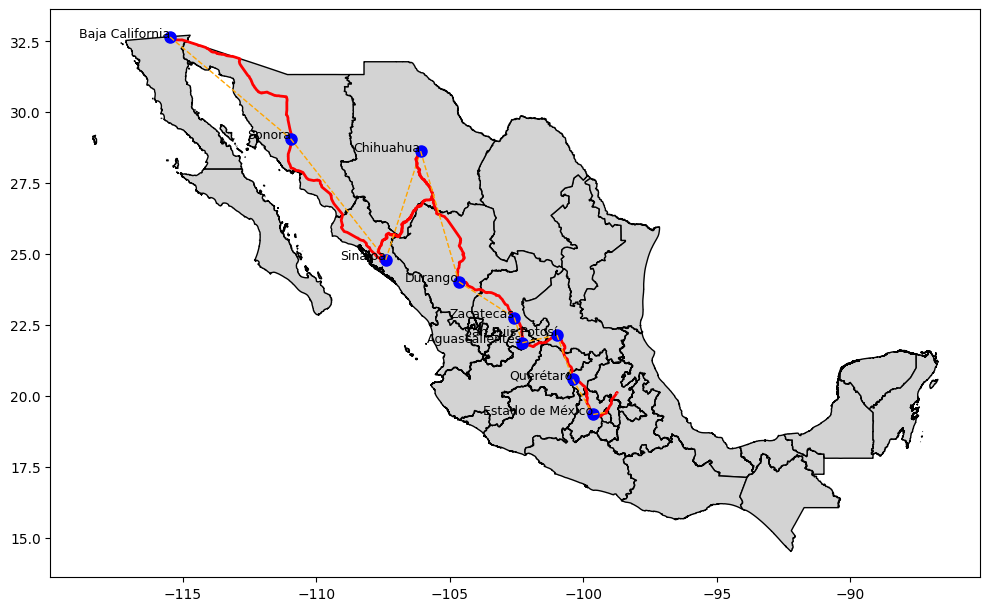

In [ ]:
import random
import matplotlib.pyplot as plt

# Parámetros para el algoritmo ACO
NUM_HORMIGAS = 10
ITERACIONES = 50
ALFA = 1.0  # Importancia de la feromona
BETA = 5.0  # Importancia de la heurística (1 / distancia)
EVAPORACION = 0.5  # Tasa de evaporación de feromonas
Q = 100  # Intensidad de feromonas depositadas

# import cost matrix from csv
costos_df = pd.read_csv("cost_matrix.csv", index_col=0)

costos = costos_df.values  # Convertir a una matriz NumPy
ciudades = list(costos_df.index)

# Inicializar matriz de feromonas
num_ciudades = len(ciudades)
feromonas = np.ones((num_ciudades, num_ciudades))

def calcular_probabilidades(ciudad_actual, no_visitadas, feromonas, heuristica, alfa, beta):
    probabilidades = []
    for ciudad in no_visitadas:
        feromona = feromonas[ciudad_actual, ciudad] ** alfa
        heuristic = heuristica[ciudad_actual, ciudad] ** beta
        probabilidades.append(feromona * heuristic)
    suma_probabilidades = sum(probabilidades)
    return [p / suma_probabilidades for p in probabilidades]

def aco(costos, num_hormigas, iteraciones, alfa, beta, evaporacion, q):
    num_ciudades = costos.shape[0]
    heuristica = 1 / (costos + np.eye(num_ciudades) * 1e9)  # Inversa de distancia
    feromonas = np.ones((num_ciudades, num_ciudades))

    mejor_ruta = None
    mejor_costo = float('inf')

    # crear directorio para las imagenes
    if not os.path.exists("images/aco"):
        os.makedirs("images/aco")

    for iteracion in range(iteraciones):
        rutas = []
        costos_rutas = []

        # crear directorio para la iteracion
        if not os.path.exists(f"images/aco/iteracion_{iteracion}"):
            os.makedirs(f"images/aco/iteracion_{iteracion}")

        for hormiga_num in range(num_hormigas):
            ruta = [random.randint(0, num_ciudades - 1)]

            # # crear directorio para la hormiga
            # if not os.path.exists(f"images/aco/iteracion_{iteracion}/hormiga_{hormiga_num}"):
            #     os.makedirs(f"images/aco/iteracion_{iteracion}/hormiga_{hormiga_num}")

            image_counter = 0

            while len(ruta) < num_ciudades:
                ciudad_actual = ruta[-1]
                no_visitadas = [ciudad for ciudad in range(num_ciudades) if ciudad not in ruta]
                probabilidades = calcular_probabilidades(ciudad_actual, no_visitadas, feromonas, heuristica, alfa, beta)
                siguiente_ciudad = random.choices(no_visitadas, weights=probabilidades)[0]

                # Guardar imagen de la ruta si es multiplo de 10 o la ultima ciudad
                # if image_counter % 10 == 0 or image_counter == num_ciudades - 1:
                if len(ruta) == num_ciudades - 1:
                    # save the tried route
                    # plot_route(
                    #     [ciudades[i] for i in ruta + [siguiente_ciudad]],
                    #     f"images/aco/iteracion_{iteracion}/hormiga_{hormiga_num}/ruta_{len(ruta)}"
                    # )
                    plot_route(
                        [ciudades[i] for i in ruta + [siguiente_ciudad]],
                        f"images/aco/iteracion_{iteracion}/hormiga_{hormiga_num}"
                    )



                image_counter += 1

                # para la ultima hormiga en la ultima iteracion guardar imagen por cada ciudad
                if iteracion == iteraciones - 1 and hormiga_num == num_hormigas - 1:
                    # save the tried route
                    plot_route(
                        [ciudades[i] for i in ruta + [siguiente_ciudad]],
                        f"images/aco/iteracion_{iteracion}/hormiga_{hormiga_num}_ruta_{len(ruta)}"
                    )

                ruta.append(siguiente_ciudad)

            ruta.append(ruta[0])  # Volver a la ciudad inicial
            rutas.append(ruta)

            costo_ruta = sum(costos[ruta[i], ruta[i + 1]] for i in range(len(ruta) - 1))
            costos_rutas.append(costo_ruta)

            if costo_ruta < mejor_costo:
                mejor_costo = costo_ruta
                mejor_ruta = ruta

        # Actualización de feromonas
        feromonas *= (1 - evaporacion)
        for ruta, costo_ruta in zip(rutas, costos_rutas):
            for i in range(len(ruta) - 1):
                feromonas[ruta[i], ruta[i + 1]] += q / costo_ruta

        print(f"Iteración {iteracion + 1}/{iteraciones}, Mejor costo: {mejor_costo}")

    return mejor_ruta, mejor_costo

# Ejecutar el algoritmo ACO
mejor_ruta, mejor_costo = aco(costos, NUM_HORMIGAS, ITERACIONES, ALFA, BETA, EVAPORACION, Q)

# Convertir la ruta a nombres de ciudades
mejor_ruta_ciudades = [ciudades[i] for i in mejor_ruta]

print("Mejor ruta encontrada:", mejor_ruta_ciudades)
print("Costo de la mejor ruta:", mejor_costo)



## Algoritmo GA

In [ ]:
# Parámetros para el Algoritmo Genético (GA)
import random

TAMANIO_POBLACION = 100
NUM_GENERACIONES = 200
TASA_MUTACION = 0.1


# import cost matrix from csv
costos_df = pd.read_csv("cost_matrix.csv", index_col=0)

costos = costos_df.values  # Convertir a una matriz NumPy
ciudades = list(costos_df.index)


# Generar una población inicial (rutas aleatorias)
def generar_poblacion(tamano_poblacion, num_ciudades):
    return [random.sample(range(num_ciudades), num_ciudades) for _ in range(tamano_poblacion)]

# Función de evaluación: costo de la ruta
def evaluar_ruta(ruta):
    return sum(costos[ruta[i], ruta[i + 1]] for i in range(len(ruta) - 1))

# Selección por torneo
def seleccion_por_torneo(poblacion, fitness, k=3):
    seleccionados = random.choices(range(len(poblacion)), k=k)
    mejor = min(seleccionados, key=lambda i: fitness[i])
    return poblacion[mejor]

# Cruce de rutas (Orden 1 Crossover - OX)
def cruce_orden(padre1, padre2):
    inicio, fin = sorted(random.sample(range(len(padre1)), 2))
    hijo = [None] * len(padre1)
    hijo[inicio:fin] = padre1[inicio:fin]
    puntos_faltantes = [ciudad for ciudad in padre2 if ciudad not in hijo]
    indice = 0
    for i in range(len(hijo)):
        if hijo[i] is None:
            hijo[i] = puntos_faltantes[indice]
            indice += 1
    return hijo

# Mutación (swap)
def mutacion(ruta, tasa_mutacion):
    if random.random() < tasa_mutacion:
        i, j = random.sample(range(len(ruta)), 2)
        ruta[i], ruta[j] = ruta[j], ruta[i]
    return ruta

# Algoritmo Genético
poblacion = generar_poblacion(TAMANIO_POBLACION, len(capitales_df))
mejor_ruta_ga = None
mejor_costo_ga = float('inf')
progreso_ga = []

# definir directorio para guardar las imagenes
if not os.path.exists("images/ga"):
    os.makedirs("images/ga")


for generacion in range(NUM_GENERACIONES):

    # progreso
    print(f"Generación {generacion + 1}/{NUM_GENERACIONES}")

    # crear directorio para la generacion
    if not os.path.exists(f"images/ga/generacion_{generacion}"):
        os.makedirs(f"images/ga/generacion_{generacion}")

    # Evaluar fitness
    fitness = [evaluar_ruta(ruta) for ruta in poblacion]
    mejor_generacion = min(fitness)
    progreso_ga.append(mejor_generacion)
    
    if mejor_generacion < mejor_costo_ga:
        mejor_costo_ga = mejor_generacion
        mejor_ruta_ga = poblacion[fitness.index(mejor_generacion)]
    
    
    # Crear nueva población
    nueva_poblacion = []

    count = 0
    for _ in range(TAMANIO_POBLACION // 2):
        # Selección
        padre1 = seleccion_por_torneo(poblacion, fitness)
        padre2 = seleccion_por_torneo(poblacion, fitness)
        # Cruce
        hijo1 = cruce_orden(padre1, padre2)
        hijo2 = cruce_orden(padre2, padre1)
        # Mutación
        nueva_poblacion.append(mutacion(hijo1, TASA_MUTACION))
        nueva_poblacion.append(mutacion(hijo2, TASA_MUTACION))

        # guardar la ruta
        plot_route(
            [ciudades[i] for i in hijo1],
            f"images/ga/generacion_{generacion}/ruta_{count}"
        )

        count += 1
    
    poblacion = nueva_poblacion

# Mostrar resultados finales
print(f"Mejor costo encontrado por GA: {mejor_costo_ga}")
print("Mejor ruta (GA):", [capitales_df.iloc[i]["Capital"] for i in mejor_ruta_ga])

# Visualizar progreso de la solución
plt.figure(figsize=(10, 6))
plt.plot(progreso_ga, marker='o')
plt.title("Progreso del Algoritmo Genético (GA)")
plt.xlabel("Generación")
plt.ylabel("Costo de la mejor solución")
plt.grid()
plt.savefig("images/ga_progress.png")